# Labels and anonymization
In this notebook we transfer the labels annotated manually in the viral messages to the entire corpus and remove personal data such as phone numbers present in the text.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
import unicodedata, re, itertools, sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.spatial import distance
%matplotlib inline
sns.set(style="darkgrid")

In [52]:
df = pd.read_csv('data/2018/wpp_2018_stage1.csv')
df.tail(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text
282676,-3459365403520904542,28/10/18,21:48,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>
282677,-3459365403520904542,28/10/18,22:06,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>
282678,-3459365403520904542,28/10/18,22:08,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>
282679,-3459365403520904542,28/10/18,22:12,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>
282680,-3459365403520904542,28/10/18,23:12,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>


In [53]:
#TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
print(X.shape)

(282681, 83880)


In [54]:
#get viral messages and use them to manually insert labels
to_label = df.drop_duplicates(subset=['text'])
to_label = to_label.sort_values(by='sharings',ascending = False)
to_label = to_label[to_label['sharings']>1]
to_label = to_label.sort_values(by = 'sharings', ascending = False)

tfidf = vectorizer.transform(to_label['text'])
to_label['VEC'] = [vec for vec in tfidf]
len(to_label)
to_label.head()
to_label.to_csv('labels/2018/to_label_2018.csv', index=False)

# After the manual annotation process...
Mapping the labels to all the corpus

In [55]:
tfidf = vectorizer.transform(df['text'])
df['VEC'] = [vec for vec in tfidf]

In [56]:
#labels
labels = pd.read_csv('labels/2018/labels_2018.csv', sep=',')
labels = labels[['text','misinformation']]
tfidf_labels = vectorizer.transform(labels['text'])
print(len(labels))
labels.head()

5293


,text,misinformation
0,😎😎😎😎\n😎 😎\n😎 😎\n😎😎...,0
1,*Aos eleitores de SP !*\nhttps://youtu.be/FXZe...,1
2,"Repassem muito ,esse video precisa chegar nas ...",1
3,Olhem os absurdos que fala do JB 😡😡😡😡,0
4,Mentira tem perna curta mesmo kkkk,0


In [57]:
labels['misinformation'].unique()

array([0, 1])

In [58]:

labeled_msg = list(labels['text'])
label = list(labels['misinformation'])
msg_txt = list(df['text'])
msg_vec = list(df['VEC'])

best_msgs = []
best_labels = []
best_dists = []

cen = len(msg_vec)/10

for i,msg in enumerate(msg_vec):
    
    if(i%cen==0):
        print(str(i/cen) + '/10')
    
    cosine_similarities = linear_kernel(msg, tfidf_labels).flatten()
    best_match_ix = np.argmax(cosine_similarities)            
    best_msgs.append(labeled_msg[best_match_ix])
    best_labels.append(label[best_match_ix])
    best_dists.append(np.max(cosine_similarities))    
    
df['BEST_MATCH'] = best_msgs
df['BEST_DIST'] = best_dists
df['BEST_LABEL'] = best_labels

0.0/10


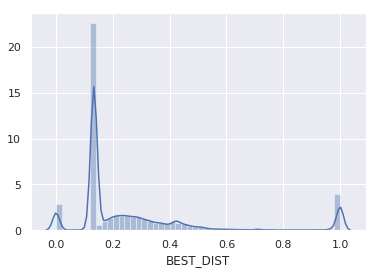

In [59]:
sns.distplot(df['BEST_DIST'])

In [60]:
df[(df['BEST_DIST'] > 0.9)][['text','BEST_MATCH']]

,text,BEST_MATCH
1,O Bolsonaro tem que estar preparado pra respon...,O Bolsonaro tem que estar preparado pra respon...
15,"No dia 07 de Outubro, quando for votar, não es...","No dia 07 de Outubro, quando for votar, não es..."
26,Devido a aborrecimentos nas varias redes socia...,Devido a aborrecimentos nas varias redes socia...
43,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...
73,"O Brasil que eu quero, é um Brasil com mais FR...","O Brasil que eu quero, é um Brasil com mais *F..."
...,...,...
282635,👏👏👏👏 \nTerminou a apuração dos votos no JAPÃO ...,Terminou a apuração dos votos no JAPÃO 😍\n97% ...
282636,https://youtu.be/UwDXPrFkU7M\n\n😡Notícias URGE...,https://youtu.be/UwDXPrFkU7M\n\n😡Notícias URGE...
282638,https://m.facebook.com/story.php?story_fbid=19...,https://m.facebook.com/story.php?story_fbid=19...
282644,#B17\n#B17\n#B17\n#B17\n#B17\n#B17\n#B17\n#B17...,#B17\n#B17\n#B17\n#B17\n#B17\n#B17\n#B17\n#B17...


In [61]:
df.columns

Index(['id', 'date', 'hour', 'ddi', 'country', 'country_iso3', 'ddd', 'state',
       'group', 'midia', 'url', 'characters', 'words', 'viral', 'sharings',
       'text', 'VEC', 'BEST_MATCH', 'BEST_DIST', 'BEST_LABEL'],
      dtype='object')

In [62]:
# if viral, uses label of best match
# if not viral, uses label of best match if cosine similarity is bigger than 0.9. 
# else, label = 0

def putLabel(viral,label,sim):
    if viral == 1:
        return label
    else:
        if sim >= 0.9:
            return label
        else:
            return 0

df['misinformation'] = df.apply(lambda x: putLabel(x['viral'], x['BEST_LABEL'], x['BEST_DIST']), axis=1)

In [63]:
cols = ['id', 'date', 'hour', 'ddi', 'country', 'country_iso3', 'ddd', 'state',
       'group', 'midia', 'url', 'characters', 'words', 'viral',
       'sharings', 'text', 'misinformation']
df = df[cols]
df

,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,0,1,Boaaa,0
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282676,-3459365403520904542,28/10/18,21:48,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
282677,-3459365403520904542,28/10/18,22:06,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
282678,-3459365403520904542,28/10/18,22:08,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
282679,-3459365403520904542,28/10/18,22:12,?,?,?,?,?,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>,0


In [64]:
#df.to_csv('data/2018/wpp_2018_v20_labeled.csv',index = False)

# ANONIMIZATION: PHONE, ADDRESSES, NAMES...

In [65]:
#df = pd.read_csv('data/2018/wpp_2018_v20_labeled.csv')

In [66]:
def haveRegex(regex,text):
    '''
    Returns True if the regex is found in text
    Input: regex, string
    Output: boolean
    '''
    matches = re.findall(regex,text)
    if matches:
        return True
    else:
        return False

In [67]:
#messages that contains phone numbers
df_query = df[df.apply(lambda x: haveRegex('telefone',x['text']),axis=1)]
print(len(df_query))
#for m in list(df_query['text'].unique()):
#    print(m)
#    print('***')

123


In [68]:
#edits phone numbers in text
df['text'] = [re.sub('\d+ \d+-\d+','[TELEFONE]',x) for x in df['text']] #XX XXXX-XXXX
df['text'] = [re.sub('\(\d+\) \d+-\d+','[TELEFONE]',x) for x in df['text']] #(XX) XXXX-XXXX
df['text'] = [re.sub('/ \d+-\d+','[TELEFONE]',x) for x in df['text']] #(XX) XXXX-XXXX / XXXX-XXXX
df['text'] = [re.sub('cel \d+-\d+','[TELEFONE]',x) for x in df['text']]#cel XXXXX-XXXX

In [69]:
#remove messages that contains names of users
df = df[df.apply(lambda x: not haveRegex('#MarqueteirosdoJair',x['text']),axis=1)]
df = df[df.apply(lambda x: not haveRegex('\*Contas para deposito\*',x['text']),axis=1)]
len(df)

282601

In [70]:
#remove links to Whatsapp groups
#df['text'] = [re.sub('https://chat.whatsapp.com/D+','https://chat.whatsapp.com/',x) for x in df['MENSAGEM']] #https://chat.whatsapp.com/XXXXXX

In [71]:
df.to_csv('data/2018/fakeWhatsApp.BR_2018.csv',index = False)

# NEXT STAGE: exploratory analysis